In [43]:
import numpy as np
import pandas as pd

#deal with the .fcs file format
import fcsparser

In [44]:
#plotting things

#%matplotlib qt5 -- I don't know what this is
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from cycler import cycler


#All of Anandh's customized seaborn/matplotlib settings

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')

    #If you want to use a different font
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(9,8))

## Working on gating

In [45]:
#set some variables

syto_channel = 'mKate/APC-A'
yfp_channel = 'GFP/FITC-A'
bfp_channel = 'CFP/VioBlue-A'

In [46]:
#get your ids

#I created a csv file that correlates fcs file number to well and volume flowed
ids_xlsx_path = '../Local Data/20181009 top 4 A B cell vars A=B flow samples/23hr/23hr-fcs num to well ID.xlsx'

ids = pd.read_excel(ids_xlsx_path, dtype=str)

### functions

In [47]:
def get_dataframe_from_fcs (desired_well, ids_frame):
    
    #get the index of the well you want in the ids frame
    idx = ids_frame['well'] == desired_well
    
    #gotta get values, which is an array, hence the [0], to get the actual string inside the array
    #because fcsparser only takes string input, can't deal with dataframe slices or arrays
    path = ids_frame.loc[idx, 'file'].values[0]
    
    #use fcsparser to unpack fcs file to dataframe, get both the metadata and dataframe in case you want both
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    
    return meta, data

In [48]:
def slice_gate (data, channel_to_gate, hi_val, lo_val):
    
    #create the indices of the desired slice
    cond1 = data[channel_to_gate] > lo_val
    cond2 = data[channel_to_gate] < hi_val

    #get the whole dataframe within the gate
    gateslice = data.loc[(cond1 & cond2), :]
    
    return gateslice

### *Syto channel gating*

### pick some experimental wells to plot raw without gating

In [49]:
wellsIwant = ['C8', 'D8']

Text(0.5, 0, 'Syto62')

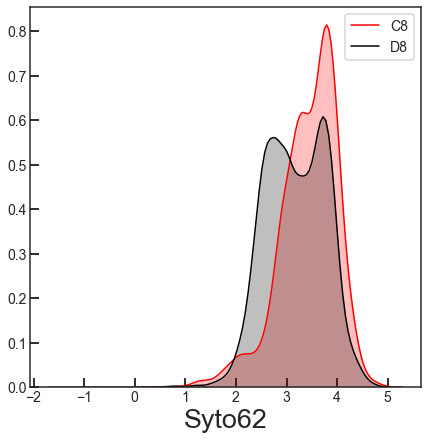

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))

for well in wellsIwant:
    
    idx = ids['well'] == well
    
    #gotta get values, which is an array, hence the [0], to get the actual string inside the array
    #because fcsparser only takes string input, can't deal with dataframe slices or arrays
    path = ids.loc[idx, 'file'].values[0]
    
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    
    
    #THIS ISN'T FINAL, I WANT TO COLLECT THE VARIOUS DATAS TOGETHER IN SOME LIST OR SOMETHING
    #FOR NOW I'M JUST DOING THIS PLOTTING ALTOGETHER IN A LOOP TO GET PLOTS
    
    #some of the values are negative, get rid of that 
    for col in data.columns:
        data.loc[data[col] < 0, col] = np.nan
        
    sns.kdeplot(np.log10(data[syto_channel]), shade=True, ax=ax)

ax.legend(wellsIwant)
ax.set_xlabel('Syto62')

### plot all the control cells on the same plot

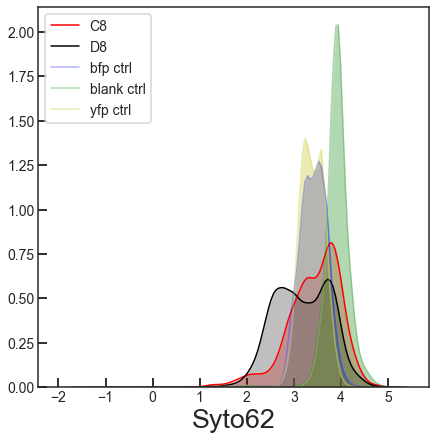

In [51]:
for ctrl in finalctrlfcs:

    meta, data = fcsparser.parse(ctrl, meta_data_only=False, reformat_meta=True)

    #some of the values are negative, get rid of that 
    for col in data.columns:
        data.loc[data[col] < 0, col] = np.nan

    sns.kdeplot(np.log10(data[syto_channel]), shade=True, ax=ax, alpha = 0.3)

ax.legend (wellsIwant + ['bfp ctrl', 'blank ctrl', 'yfp ctrl'])
    
fig

### eyeball gating to exclude negative cells

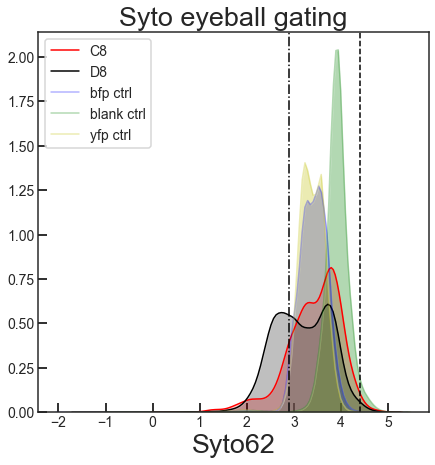

In [52]:
#set the values
syto_hi_gate = 25000
syto_lo_gate = 800

#plot them to show it
ax.axvline(np.log10(syto_hi_gate), color='k', linestyle='--')
ax.axvline(np.log10(syto_lo_gate), color='k', linestyle='-.')

#make clear on figure
ax.set_title('Syto eyeball gating')

fig

### *from adding veritcal lines to above plot, an mKate channel value of* 25000 > value > 800 *seems to be a good starting gate for syto for non blank cells, those cells are really bright in syto (prob because are log phase comp cells with more DNA)*

### *YFP channel gating*

In [53]:
#use same wellsIwant

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


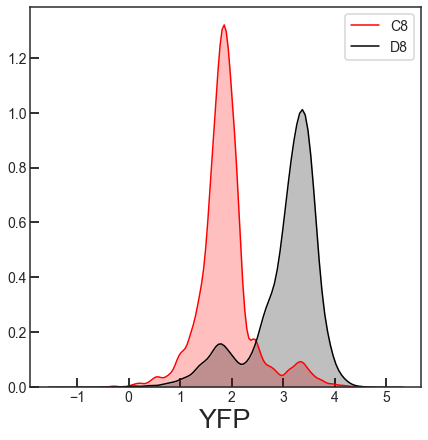

In [54]:
fig1, ax1 = plt.subplots(figsize=(7,7))

for well in wellsIwant:

    meta, data = get_dataframe_from_fcs(well, ids)
    
    gateslice = slice_gate (data, syto_channel, syto_hi_gate, syto_lo_gate)

    sns.kdeplot(np.log10(gateslice[yfp_channel]), shade=True, ax=ax1)
    
ax1.set_xlabel('YFP')

ax1.legend(wellsIwant)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


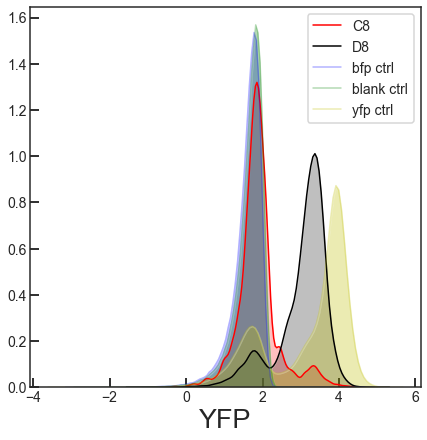

In [55]:
for ctrl in finalctrlfcs:

    meta, data = fcsparser.parse(ctrl, meta_data_only=False, reformat_meta=True)

    gateslice = slice_gate (data, syto_channel, syto_hi_gate, syto_lo_gate)

    sns.kdeplot(np.log10(gateslice[yfp_channel]), shade=True, ax=ax1, alpha = 0.3)

ax1.legend (wellsIwant + ['bfp ctrl', 'blank ctrl', 'yfp ctrl'])
    
fig1

### eyeball gating to exclude negative cells

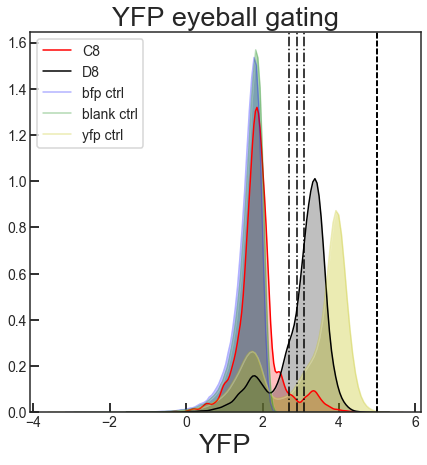

In [58]:
#set the values
yfp_hi_gate = 100000
yfp_lo_gate = 500 #1200 for the 10min samples

#plot to show it
ax1.axvline(np.log10(yfp_hi_gate), color='k', linestyle='--')
ax1.axvline(np.log10(yfp_lo_gate), color='k', linestyle='-.')

#make clear on figure
ax1.set_title('YFP eyeball gating')

fig1

### *eyeball gating YFP channel indicates that 100,000 > value > 500 is a decent gate for this channel to separate positive and negative cells. For the 10min samples 1200 was the right YFP low cutoff*

## Plots

### Get histograms

In [59]:
#set up lists of wells you want to plot

cap_resc_wells = []
for num in '12345678':
    cap_resc_wells  += [[s + num for s in ['A', 'B']]]
    
a52s = []
for num in '1234':
    a52s += [[s + num for s in ['C', 'D']]]
    
a61s = []
for num in '5678':
    a61s += [[s + num for s in ['C', 'D']]]
    
a51s = []
for num in '1234':
    a51s += [[s + num for s in ['E', 'F']]]
    
a81s = []
for num in '1234':
    a81s += [[s + num for s in ['G', 'H']]]

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


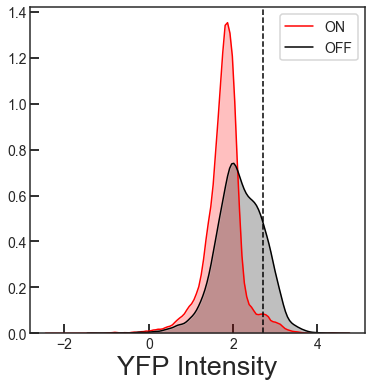

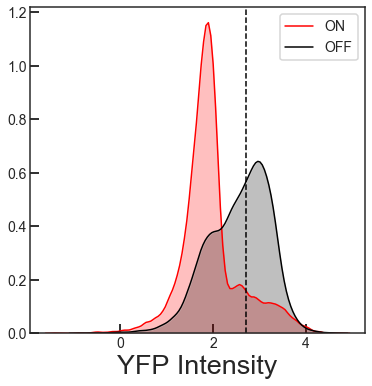

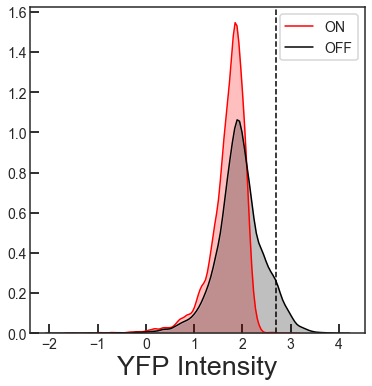

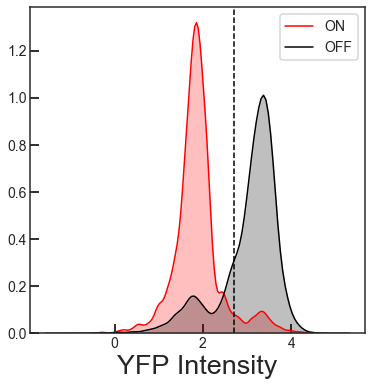

In [73]:
for pair in a61s:
    
    #remake plot each time to clear it
    fig2, ax2 = plt.subplots(figsize=(6,6))
    
    for well in pair:
        meta, data = get_dataframe_from_fcs(well, ids)
    
        gateslice = slice_gate (data, syto_channel, syto_hi_gate, syto_lo_gate)
        
        sns.kdeplot(np.log10(gateslice[yfp_channel]), shade=True, ax=ax2)
        
    #show the cutoff for positive values
    ax2.axvline(np.log10(yfp_lo_gate), color='k', linestyle='--')

    ax2.set_xlabel('YFP Intensity')
    ax2.legend(['ON', 'OFF'])

    #fig2.savefig('../Local Data/20181009 exp figs/10min/a52s-wells{}{}-YFP.pdf'.format(pair[0], pair[1]))

### get something like what the MACSquant would show you

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log", yscale="log")

ax.set_xlim([10**-2, 10**6])
ax.set_ylim([1, 10**6])

ax.scatter(data['CFP/VioBlue-A'], data['SSC-A'], alpha=0.1, marker='o', s=1)

In [ ]:
#havent figured out how to get a color coded density plot yet without using seaborn kde plot which seems to hang
#and not generate anything